Nan values per column:   
 LINENAME         0
LINEWAVE         0
LINEZ            0
LINEZ_ERR        1
LINESIGMA        0
LINESIGMA_ERR    0
file_name        0
dtype: int64
           LINENAME     LINEWAVE     LINEZ  LINEZ_ERR    LINESIGMA  \
4    b'C_III] 1908'  1908.734000  0.000000  -1.000000     0.000000   
2      b'C_IV 1549'  1549.480000  0.000000  -1.000000     0.000000   
27       b'H_alpha'  6564.613974  0.000421   0.000025    91.300972   
16        b'H_beta'  4862.683021  0.000421   0.000025    91.300972   
12       b'H_delta'  4102.891635  0.000421   0.000025    91.300972   
..              ...          ...       ...        ...          ...   
23    b'[O_I] 6300'  6302.046448 -0.001670   0.003476  7257.452637   
25    b'[O_I] 6363'  6365.535493 -0.001671   0.003476  7257.452637   
24  b'[S_III] 6312'  6313.805605 -0.001672   0.003476  7257.452637   
29   b'[S_II] 6716'  6718.294292 -0.001671   0.003476  7257.452637   
30   b'[S_II] 6730'  6732.678161 -0.001671   0.003476  72

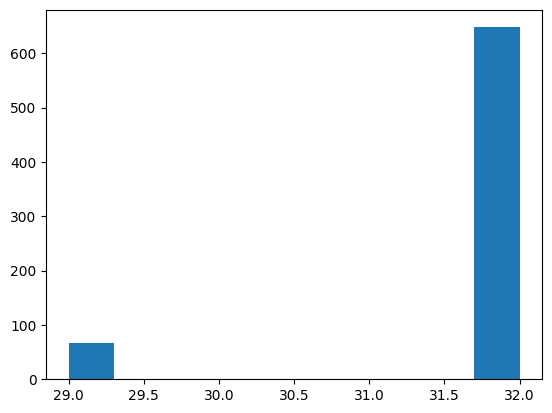

In [3]:

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)
import pandas as pd
from astropy.table import Table 
from astropy.io import fits
import matplotlib.pyplot as plt 
import torch
import numpy as np 
import SplinesNLines 



np.random.seed(201763)

all_data = pd.read_csv('Selection2_les_astro_guapes.csv') #Reads record data. 
all_data = all_data.drop_duplicates(subset= ['sdss_id'])
file_names = all_data['sas_file'].to_list() #Places all file names in a list. 
f1 = file_names[0]

"""
Note: Line profile information is read first to see which line profile information is available and how it varies. 
"""
#Read information for line profiles-----------------------------------------------------------------------------------------------------------
cols = ['LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR', 'LINESIGMA', 'LINESIGMA_ERR' ]

f1 = file_names[0]
table_line = Table.read(f1, hdu = 4)
table_line = table_line.to_pandas()
table_line = table_line[cols]
table_line['file_name'] = f1
no_prof = [] #Array to store the number of profiles in each file. 

var = [] #Adds to array the names of the profiles of those files with 29 recorded profiles. 
max_lam =[] #Array to store the maximum recorded value of wavelength. 
min_lam = []  #Array to store the minimum recorded value of wavelength. 
var_pos = []


"""
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')
Index(['PLATE', 'MJD', 'FIBERID', 'LINENAME', 'LINEWAVE', 'LINEZ', 'LINEZ_ERR',
       'LINESIGMA', 'LINESIGMA_ERR', 'LINEAREA', 'LINEAREA_ERR', 'LINEEW',
       'LINEEW_ERR', 'LINECONTLEVEL', 'LINECONTLEVEL_ERR', 'LINENPIXLEFT',
       'LINENPIXRIGHT', 'LINEDOF', 'LINECHI2'],
      dtype='object')

"""

for i in range(1, len(file_names)):

    oth_table = Table.read(file_names[i], hdu = 1).to_pandas()
    try:
        curr_table = Table.read(file_names[i], hdu = 4).to_pandas()
        curr_table = curr_table[cols]
        #log_lam_curr = 10**oth_table['LOGLAM']
        log_lam_curr = oth_table['LOGLAM']

    except:
        curr_table = Table.read(file_names[i], hdu = 3).to_pandas()
        curr_table = curr_table[cols]
        #log_lam_curr = 10**oth_table['loglam']
        log_lam_curr = oth_table['loglam']


    max_lam.append(log_lam_curr.max())
    min_lam.append(log_lam_curr.min())
         
    curr_table['file_name'] = len(curr_table)*[file_names[i]]
    if len(curr_table) == 29:
        var.append(curr_table['LINENAME'].to_list())
        var_pos.append(curr_table['LINEWAVE'].to_list())
    no_prof.append(len(curr_table))
    table_line = pd.concat([table_line, curr_table])

print("Nan values per column:   \n",   table_line.isnull().sum())
line_sd_mean = table_line.groupby('LINENAME')['LINESIGMA'].mean()

table_line = table_line.sort_values(['file_name','LINENAME'])
to_use_profiles = var[0]
print(table_line)

to_use_profiles = list(dict.fromkeys([(x.decode('utf-8').strip()).replace(' ', '') 
                                      if isinstance(x, bytes) else (x.strip()).replace(' ', '') for x in to_use_profiles
                                    ])) #Convert to_use_profiles elements to strings and remove spaces. 
table_line['LINENAME'] = table_line['LINENAME'].str.decode('utf-8') #Change the format from bytes to string. 
table_line['LINENAME'] = table_line['LINENAME'].str.replace(' ', '') #Replace all of spaces with empty strings. 


table_line = table_line[ (table_line['LINESIGMA'] > 0) & (table_line['LINENAME'].isin(to_use_profiles)) ] #Select only those with LINESIGMA> 0 and that 
                                                                                                          #correspond to LINENAME's that are going to be used. 
plt.hist(no_prof)
plt.show()
#-----------------------------------------------------------------------------------------------------------------------------------------------



#Note, some matrices blowing up 


In [4]:



unique_pairs = (table_line[['LINENAME', 'LINEWAVE']].drop_duplicates().groupby('LINENAME', as_index=False).agg(LINEWAVE=('LINEWAVE', 'mean')))
line_sig_mean = (table_line.groupby('LINENAME', as_index= False).agg(LINESIGMA = ('LINESIGMA', 'mean'))  )
line_df = unique_pairs.merge(line_sig_mean, on = 'LINENAME')

line_wave = np.sort(line_df['LINEWAVE'].to_numpy())


all_line_data = {
    'LINEWAVE': [1215.67, 1240.81, 1549.48, 1640.42, 1908.734, 2800.3152, 3727.0917, 
                 3729.8754, 3869.8568, 3890.1511, 3971.1232, 4102.8916, 4341.6843, 
                 4364.4353, 4686.9915, 4862.6830, 4960.2949, 5008.2397, 5413.0245, 
                 5578.8878, 5756.1862, 5877.3086, 6302.0464, 6363.776, 6313.8056, 
                 6365.5355, 6549.8590, 6564.6140, 6585.2685, 6718.2943, 6732.6782, 
                 7137.7572],
    'LINENAME': ['Ly_alpha', 'N_V 1240', 'C_IV 1549', 'He_II 1640', 'C_III] 1908', 
                 'Mg_II 2799', '[O_II] 3725', '[O_II] 3727', '[Ne_III] 3868', 
                 'H_epsilon', '[Ne_III] 3970', 'H_delta', 'H_gamma', '[O_III] 4363', 
                 'He_II 4685', 'H_beta', '[O_III] 4959', '[O_III] 5007', 'He_II 5411', 
                 '[O_I] 5577', '[N_II] 5755', 'He_I 5876', '[O_I] 6300', '[O_I] 6363', 
                 '[S_III] 6312', '[O_I] 6363', '[N_II] 6548', 'H_alpha', '[N_II] 6583', 
                 '[S_II] 6716', '[S_II] 6730', '[Ar_III] 7135'],
    'ZINDEX': ['z_lya', 'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission', 'zemission', 'zemission', 'zemission', 'zemission', 
               'zemission'],
    'WINDEX': ['w_ly_a', 'w_n_v', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'w_balmer', 'wemission', 
               'w_balmer', 'wemission', 'wemission', 'wemission', 'w_balmer', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'wemission', 'wemission', 'wemission', 'wemission', 
               'wemission', 'w_balmer', 'wemission', 'wemission', 'wemission', 
               'wemission']
}

all_line_data = pd.DataFrame(all_line_data)
line_data_use = all_line_data[(all_line_data['LINEWAVE'] > np.min(min_lam)) & (all_line_data['LINEWAVE'] < np.max(max_lam))]



In [11]:
B_f = 80 #Sets number of B-Spline functions to use. 
m = 2 #Value such that m+1 is the degree of the basis B-Spline functions. Needs: B_f + m + 2 knots. 
T = np.sort( np.concatenate([line_data_use['LINEWAVE'].to_numpy(), np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 - len(line_data_use['LINEWAVE'].to_numpy())   )  ]    ))
T = np.linspace(np.min(min_lam), np.max(max_lam), B_f + m + 2 )   


to_use_profiles_set = set(to_use_profiles)
thet_o = [] #np.zeros(  shape = ( len(file_names), B_f + len(line_wave)   ) )


not_used = []
p_inv_used = []
used = []

for o in range(len(file_names)):
    if o%100 == 0:
        print(f"Going for file {o}")

    f = file_names[o]
    curr_file = Table.read(f, hdu = 1).to_pandas() #Reads the .fits file corresponding to the Flux-wavelength data for f. 

    #For the current file, select those points without specified problems and with a stricty possitive precision parameter (IVAR).
    #The try-except helps to handle both .fits files from DR17 and DR19 without breaking the flow of execution. 
    try:
        curr_file = curr_file[(curr_file['AND_MASK'] == 0) & (curr_file['IVAR'] > 0)]
        tau_ok_name = 'IVAR'
        log_lam_name = 'LOGLAM'
        flux_name = 'FLUX'
        #curr_file_line = Table.read(f, hdu = 4).to_pandas()

    except:
        curr_file = curr_file[(curr_file['and_mask'] == 0) & (curr_file['ivar'] > 0)]
        tau_ok_name = 'ivar'
        log_lam_name = 'loglam'
        flux_name = 'flux'
        #curr_file_line = Table.open(f, hdu = 3).to_pandas()


    try:
        select_idx = [( (i+1)%np.ceil( len(curr_file)/1000) == 0  ) for i in range(len(curr_file)) ] #Reduces the number of points to use. 
        curr_file = curr_file[select_idx] #Selects the points to use. 
        line_prof_curr = table_line[table_line['file_name'] == f]#Selects the line profile information for f. 
        line_prof_curr = line_prof_curr[['LINENAME', 'LINEWAVE', 'LINESIGMA']] 

        missing_line_prof =  list(to_use_profiles_set - set(line_prof_curr['LINENAME'].to_list())) #Checks which line profiles are missing. 
        if len(missing_line_prof) > 0:
            line_prof_curr = pd.concat([line_prof_curr, line_df[line_df['LINENAME'].isin(missing_line_prof)]])

        line_prof_curr = line_prof_curr.sort_values('LINEWAVE')        
        Tau_ok = curr_file[tau_ok_name].to_numpy()
        To = curr_file[log_lam_name].to_numpy()

        X_B = SplinesNLines.get_basis_mat_B_Spline_opt(To, B_f, m, T)
        X_L = SplinesNLines.eval_Line_Profiles_opt(10**To, line_wave, line_prof_curr['LINESIGMA'].to_numpy() ) #Falta width values
        fo = (curr_file[flux_name].to_numpy()).reshape(-1,1)
        X = np.hstack((X_B, X_L))

        try: 

            tht = (np.linalg.inv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()

            if np.sum(np.isnan(tht)) > 0: 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")

            else:
                thet_o.append( tht)
                p_inv_used.append(0)
        except: 
            tht = (np.linalg.pinv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()

            if np.sum(np.isnan(tht)) > 0: 
                print(f"Error on file {f}. \n Found NaN's on estimation  \n Moving on...")
                not_used.append(f)
                print(f"Design matrix rank: {np.linalg.matrix_rank(X)}")
                print(f"Max observed value:  {np.max(fo)}")
                print(f"Min observed value: {np.min(fo)}")


            else:

                thet_o.append( tht)
                p_inv_used.append(0)
        used.append(f)


    except:
        print(f"Error on file {f}. \n Moving on...")
        not_used.append(f)




Going for file 0
Going for file 100
Going for file 200
Going for file 300


C:\Users\End User\AppData\Local\Temp\ipykernel_6416\1429786011.py:60: RuntimeWarning: invalid value encountered in matmul
  tht = (np.linalg.inv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()


Error on file spec-allepoch-60074-27021602785050616.fits. 
 Found NaN's on estimation  
 Moving on...
Design matrix rank: 107
Max observed value:  32.67655944824219
Min observed value: -18.107606887817383
Going for file 400
Going for file 500


C:\Users\End User\AppData\Local\Temp\ipykernel_6416\1429786011.py:60: RuntimeWarning: invalid value encountered in matmul
  tht = (np.linalg.inv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()


Error on file spec-7027-56448-0731.fits. 
 Found NaN's on estimation  
 Moving on...
Design matrix rank: 89
Max observed value:  20.835237503051758
Min observed value: -6.740911960601807


C:\Users\End User\AppData\Local\Temp\ipykernel_6416\1429786011.py:60: RuntimeWarning: invalid value encountered in matmul
  tht = (np.linalg.inv(X.T@np.diag(curr_file[tau_ok_name].to_numpy())@X)@X.T@np.diag(curr_file[tau_ok_name].to_numpy())@fo).flatten()


Error on file spec-9147-58038-0788.fits. 
 Found NaN's on estimation  
 Moving on...
Design matrix rank: 89
Max observed value:  4.107076168060303
Min observed value: -10.422314643859863
Going for file 600
Error on file spec-7881-57282-0453.fits. 
 Moving on...
Going for file 700


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 1.98706825e+172  0.00000000e+000  1.84349822e+096 ...  8.47875529e+100
  -1.10160090e+101  6.11734541e+100]
 [ 0.00000000e+000  1.98706825e+172  9.92964048e+156 ... -2.03393109e+146
  -3.16353222e+145 -3.95703806e+146]
 [ 1.84349822e+096  7.93466159e+156  1.98706825e+172 ... -1.14765376e+146
  -1.54387375e+146  2.15151227e+146]
 ...
 [ 8.47875529e+100 -2.03393109e+146 -1.14765376e+146 ...  1.98706825e+172
   1.73245312e+156  3.68379053e+155]
 [-1.10160090e+101 -3.16353222e+145 -1.54387375e+146 ...  1.95046728e+156
   1.98706825e+172 -2.30766172e+156]
 [ 6.11734541e+100 -3.95703806e+146  2.15151227e+146 ...  6.75662364e+155
  -2.18599460e+156  1.98706825e+1

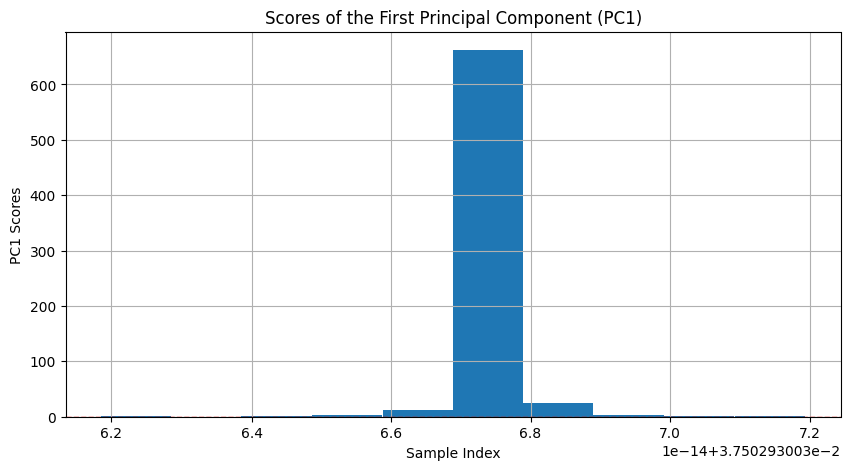

In [39]:
from sklearn.decomposition import PCA
import scipy.stats as sts
pca = PCA()
thet_o = np.array(thet_o)

pca.fit(thet_o)
pve = np.cumsum( np.array(pca.singular_values_))/np.sum(np.array(pca.singular_values_))
components = pca.components_ 


print(pve)
scores = pca.fit_transform(thet_o)  # Get all component scores
pc1_scores = scores[:, 0]  # First column
pc1_scores = pc1_scores/np.std(pc1_scores)
pc1_filtered = pc1_scores[pc1_scores != np.min(pc1_scores)]

print(pca.get_covariance())

plt.figure(figsize=(10, 5))
plt.hist(pc1_filtered)

plt.axhline(y=0, color='red', linestyle='--', linewidth=1)  # Reference line at 0
plt.xlabel('Sample Index')
plt.ylabel('PC1 Scores')
plt.title('Scores of the First Principal Component (PC1)')
plt.grid(True)
plt.show()
